In [16]:
# import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

import scarlet # for generating RGB images (solely for display purposes)

from unagi import hsc, config
from unagi import plotting
from unagi import task, catalog


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from tractor.tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_iteration

In [6]:
# load catalog and images
obj_cat = Table.read('/home/diana/Research/ladybug_tractor/ladybug/ladybug-2021-03-03.fits')

In [7]:
obj_cat['name']

ladybug_201_y
ladybug_180_y
ladybug_158_y
ladybug_151_y
ladybug_207_y
ladybug_105_y
ladybug_33_y
ladybug_10_y
ladybug_175_y
ladybug_167_y
ladybug_27_y


In [10]:
from kuaizi.tractor.utils import tractor_hsc_sep

channels = 'grizy'

# save all the files to './output'
import os
#os.chdir('./output')
os.getcwd()

'/home/diana/Research/ladybug_tractor/output'

### `ladybug_33` g-band
# Detected 2 objects
!!!The file "./tractor-1498p020.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 2
 - Now you have 1 sources
   index False out of range for table with length 0
 - Now you have 1 sources
 - Now you have 2 sources


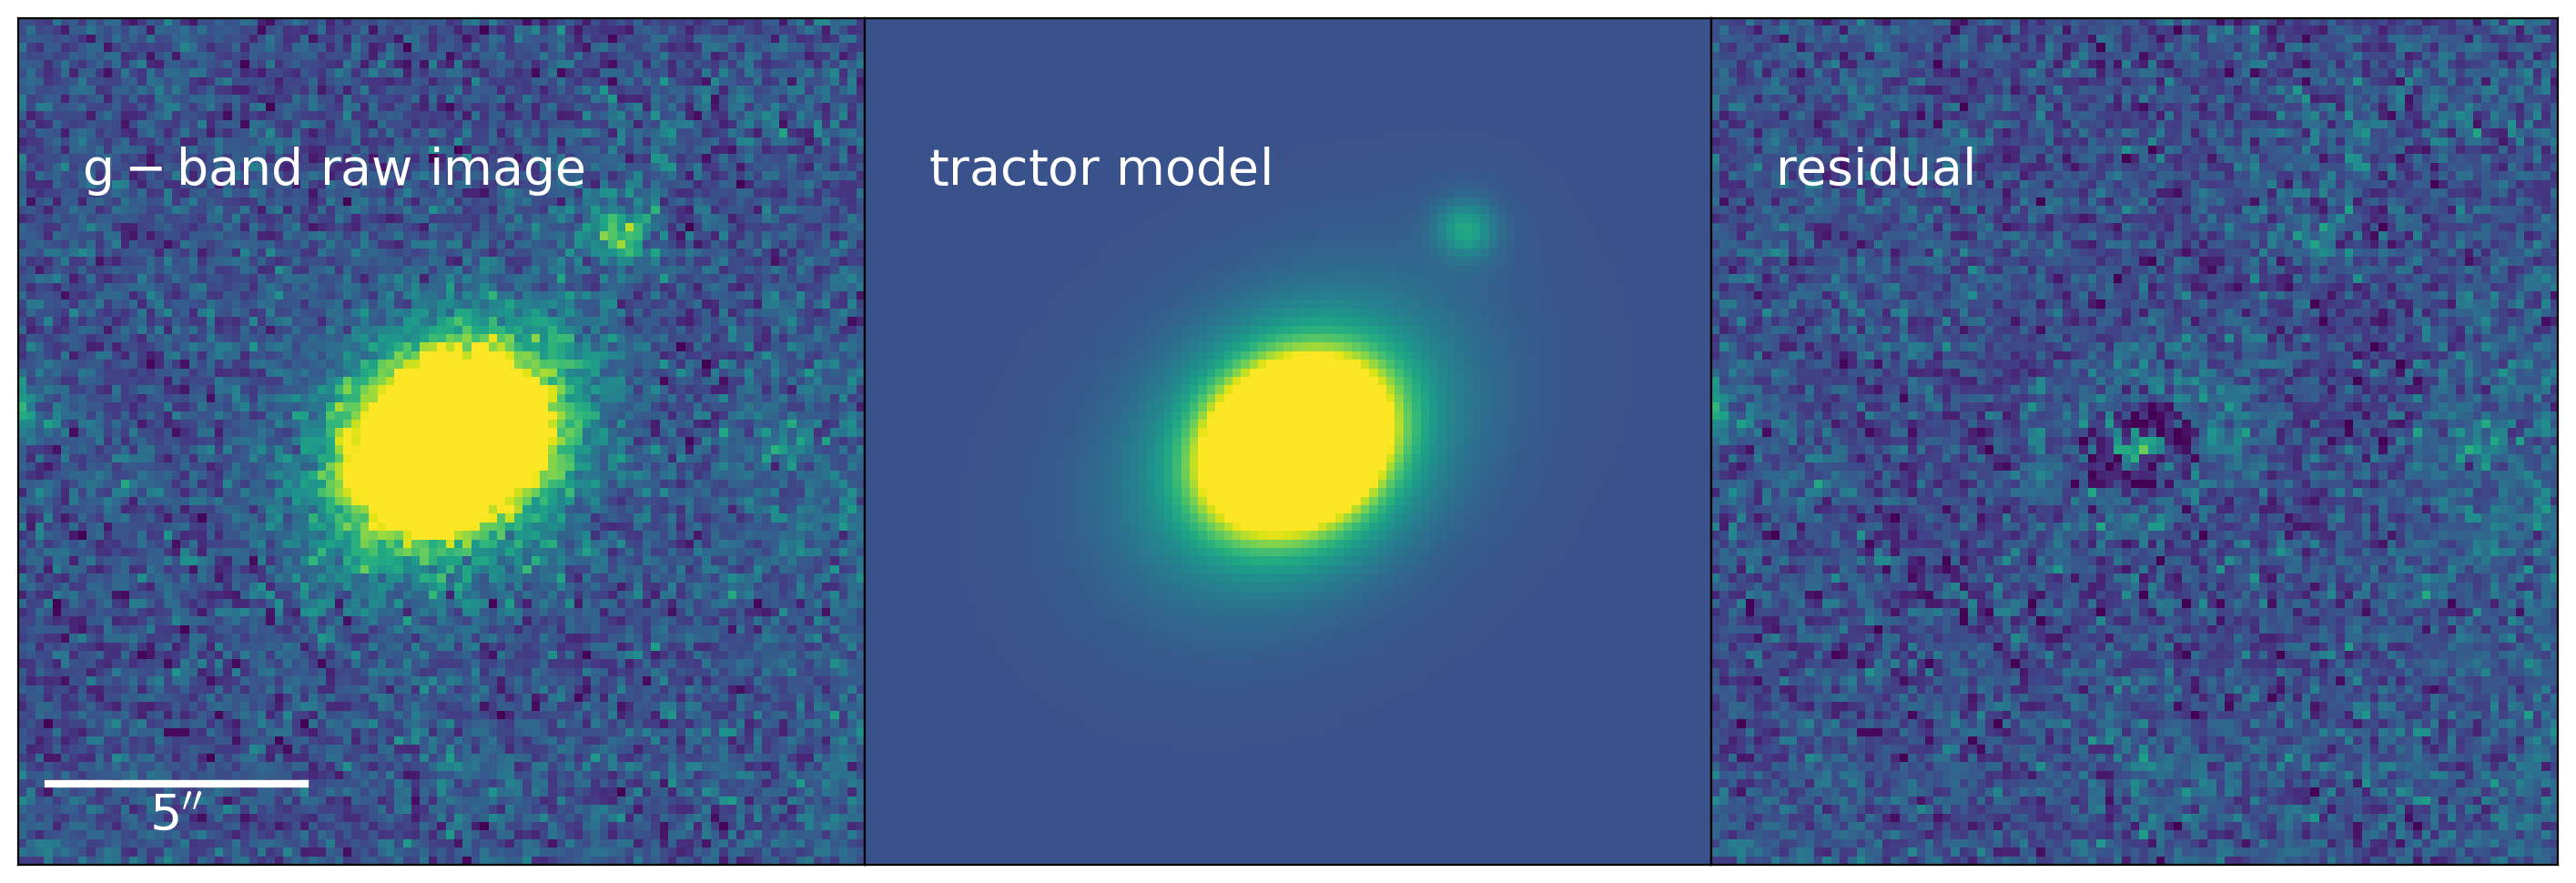

   The chi-square is 6.3041014e-05
### `ladybug_33` r-band
# Detected 2 objects
!!!The file "./tractor-1498p020.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 2
 - Now you have 1 sources
   index False out of range for table with length 0
 - Now you have 1 sources
 - Now you have 2 sources


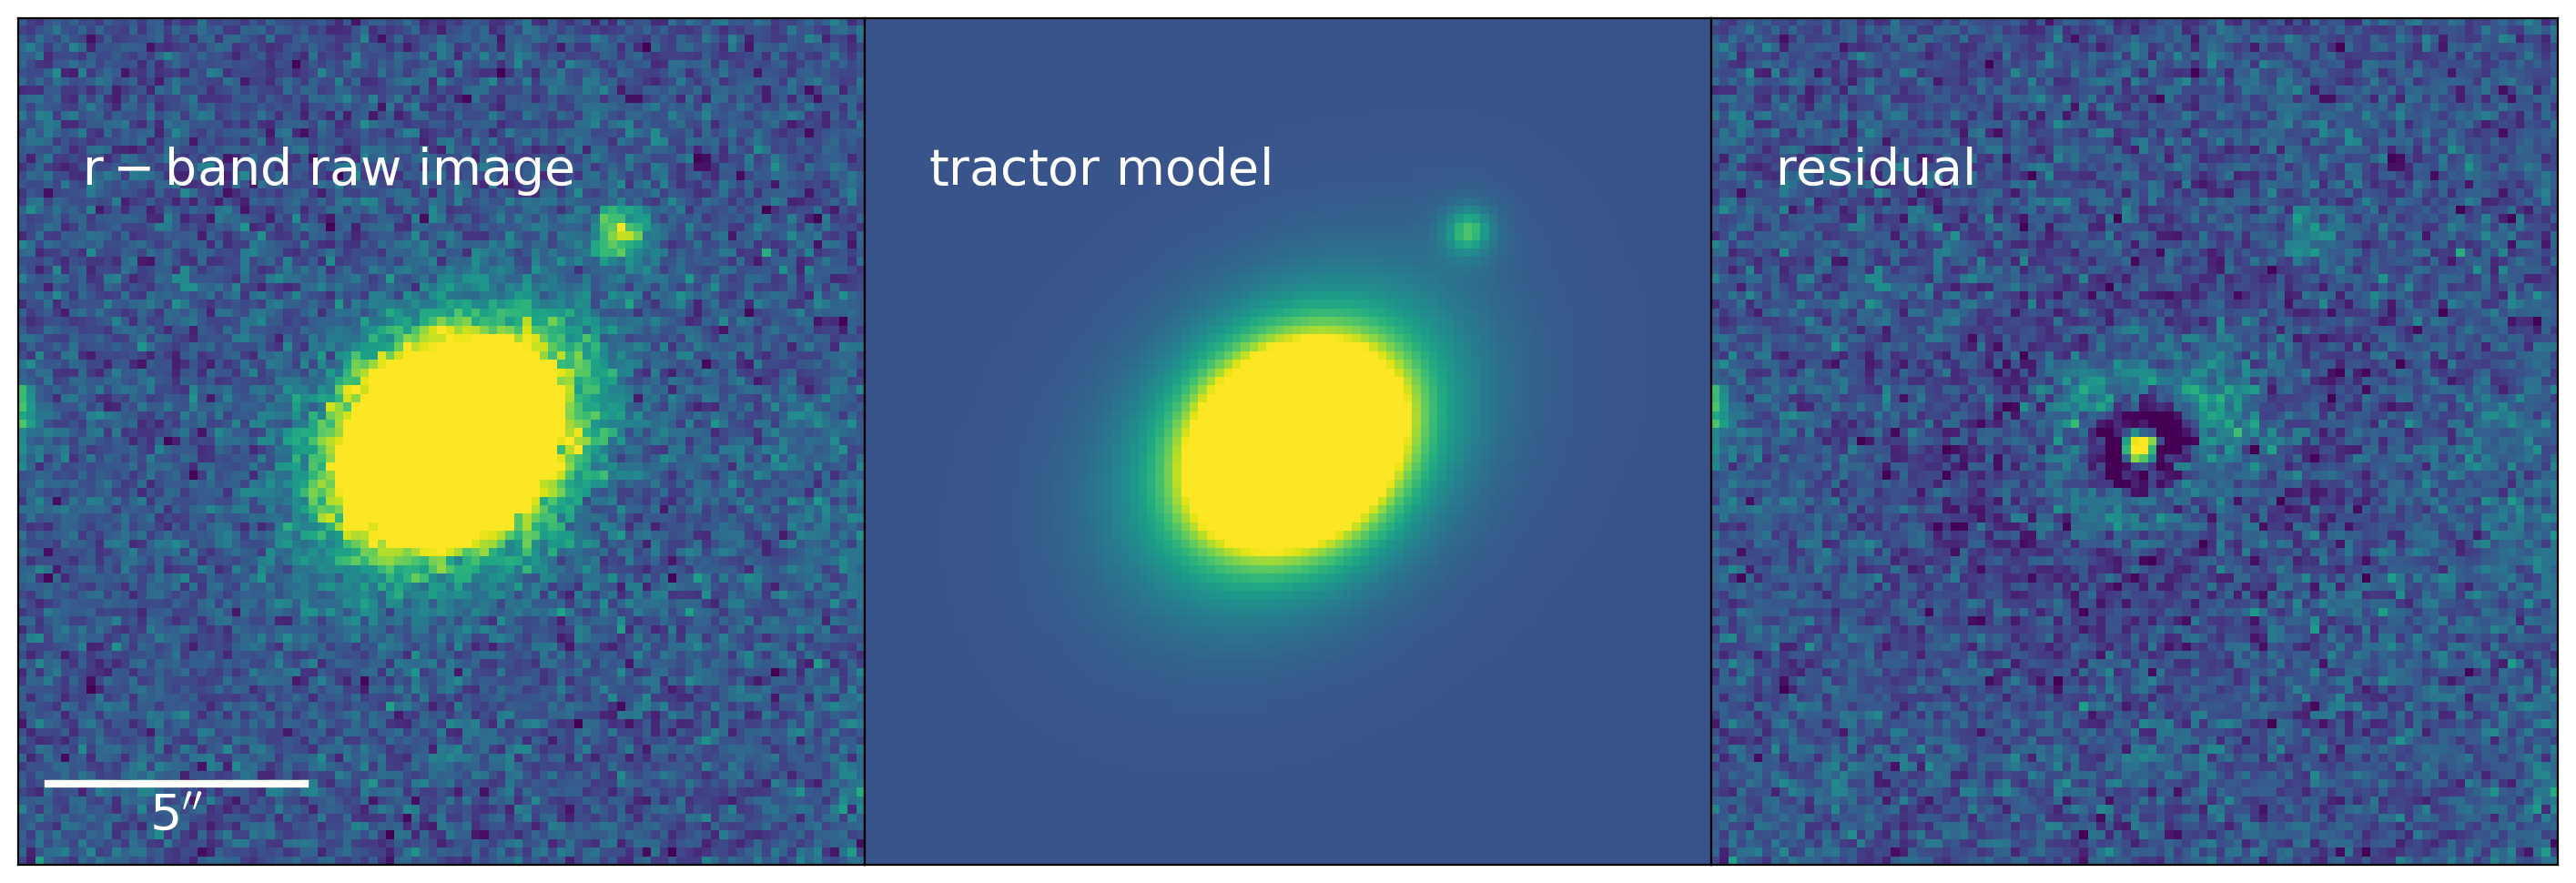

   The chi-square is 4.61191e-05
### `ladybug_33` i-band
# Detected 3 objects
!!!The file "./tractor-1498p020.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 3
 - Now you have 1 sources
 - Now you have 2 sources


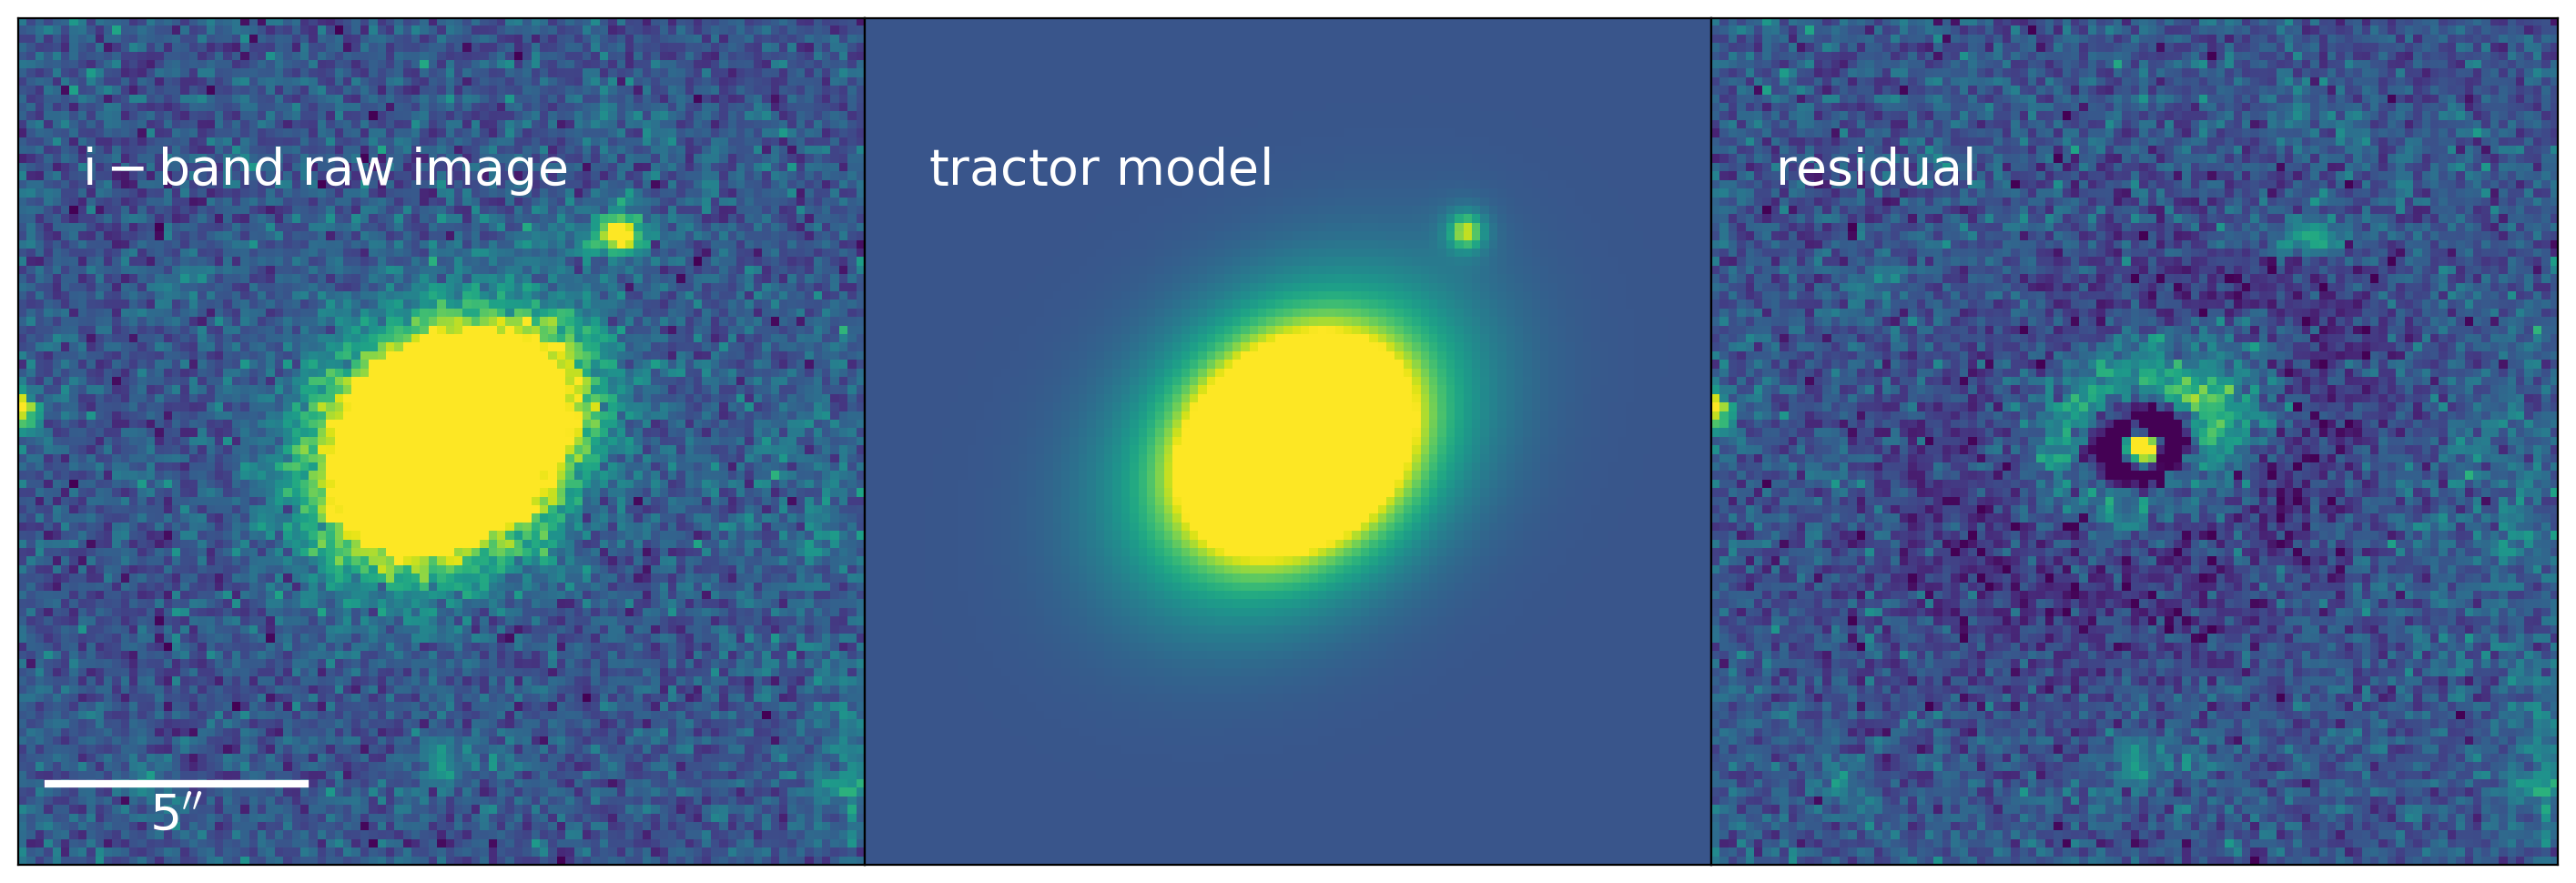

   The chi-square is 4.117652e-05
 - Now you have 3 sources


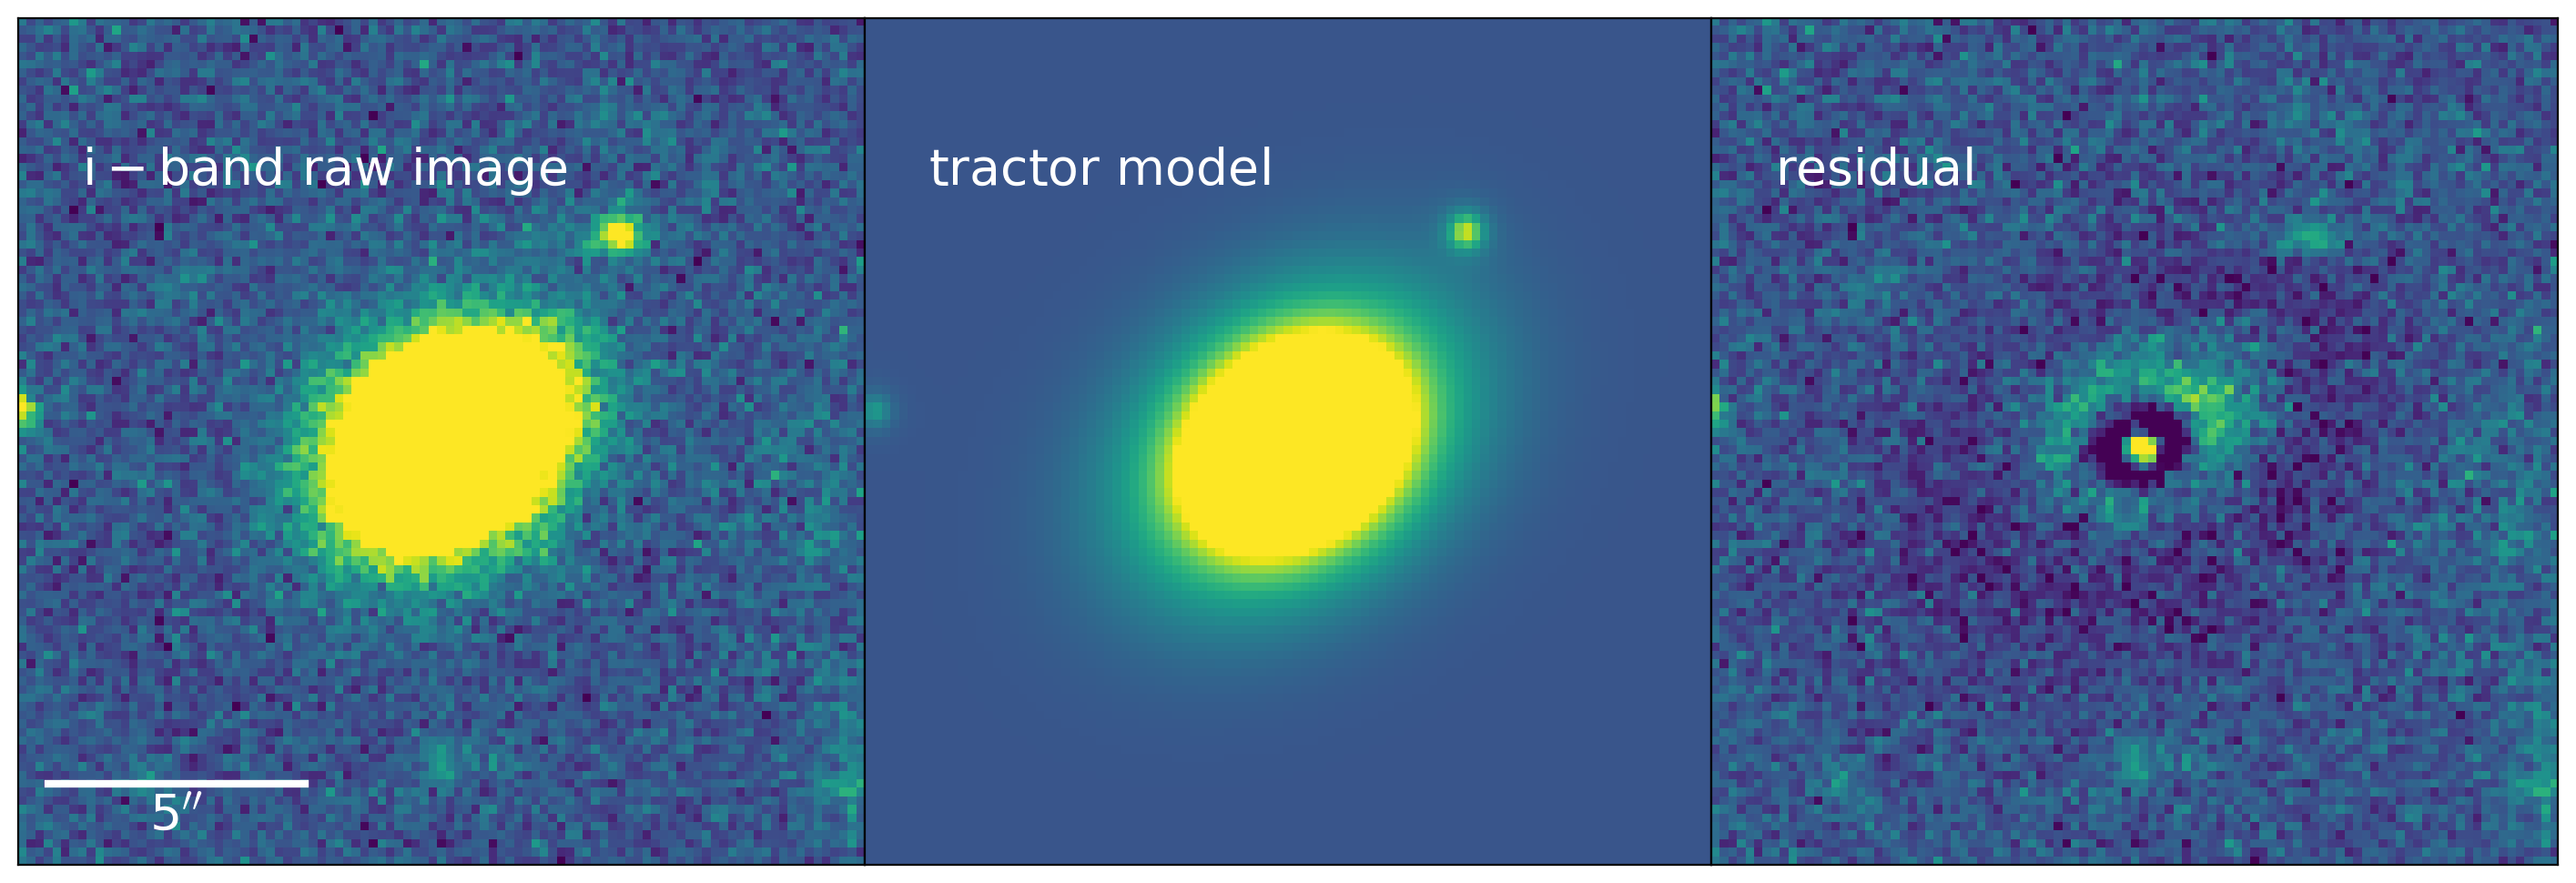

   The chi-square is 4.0908595e-05
### `ladybug_33` z-band
# Detected 2 objects
!!!The file "./tractor-1498p020.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 2
 - Now you have 1 sources
   index False out of range for table with length 0
 - Now you have 1 sources
 - Now you have 2 sources


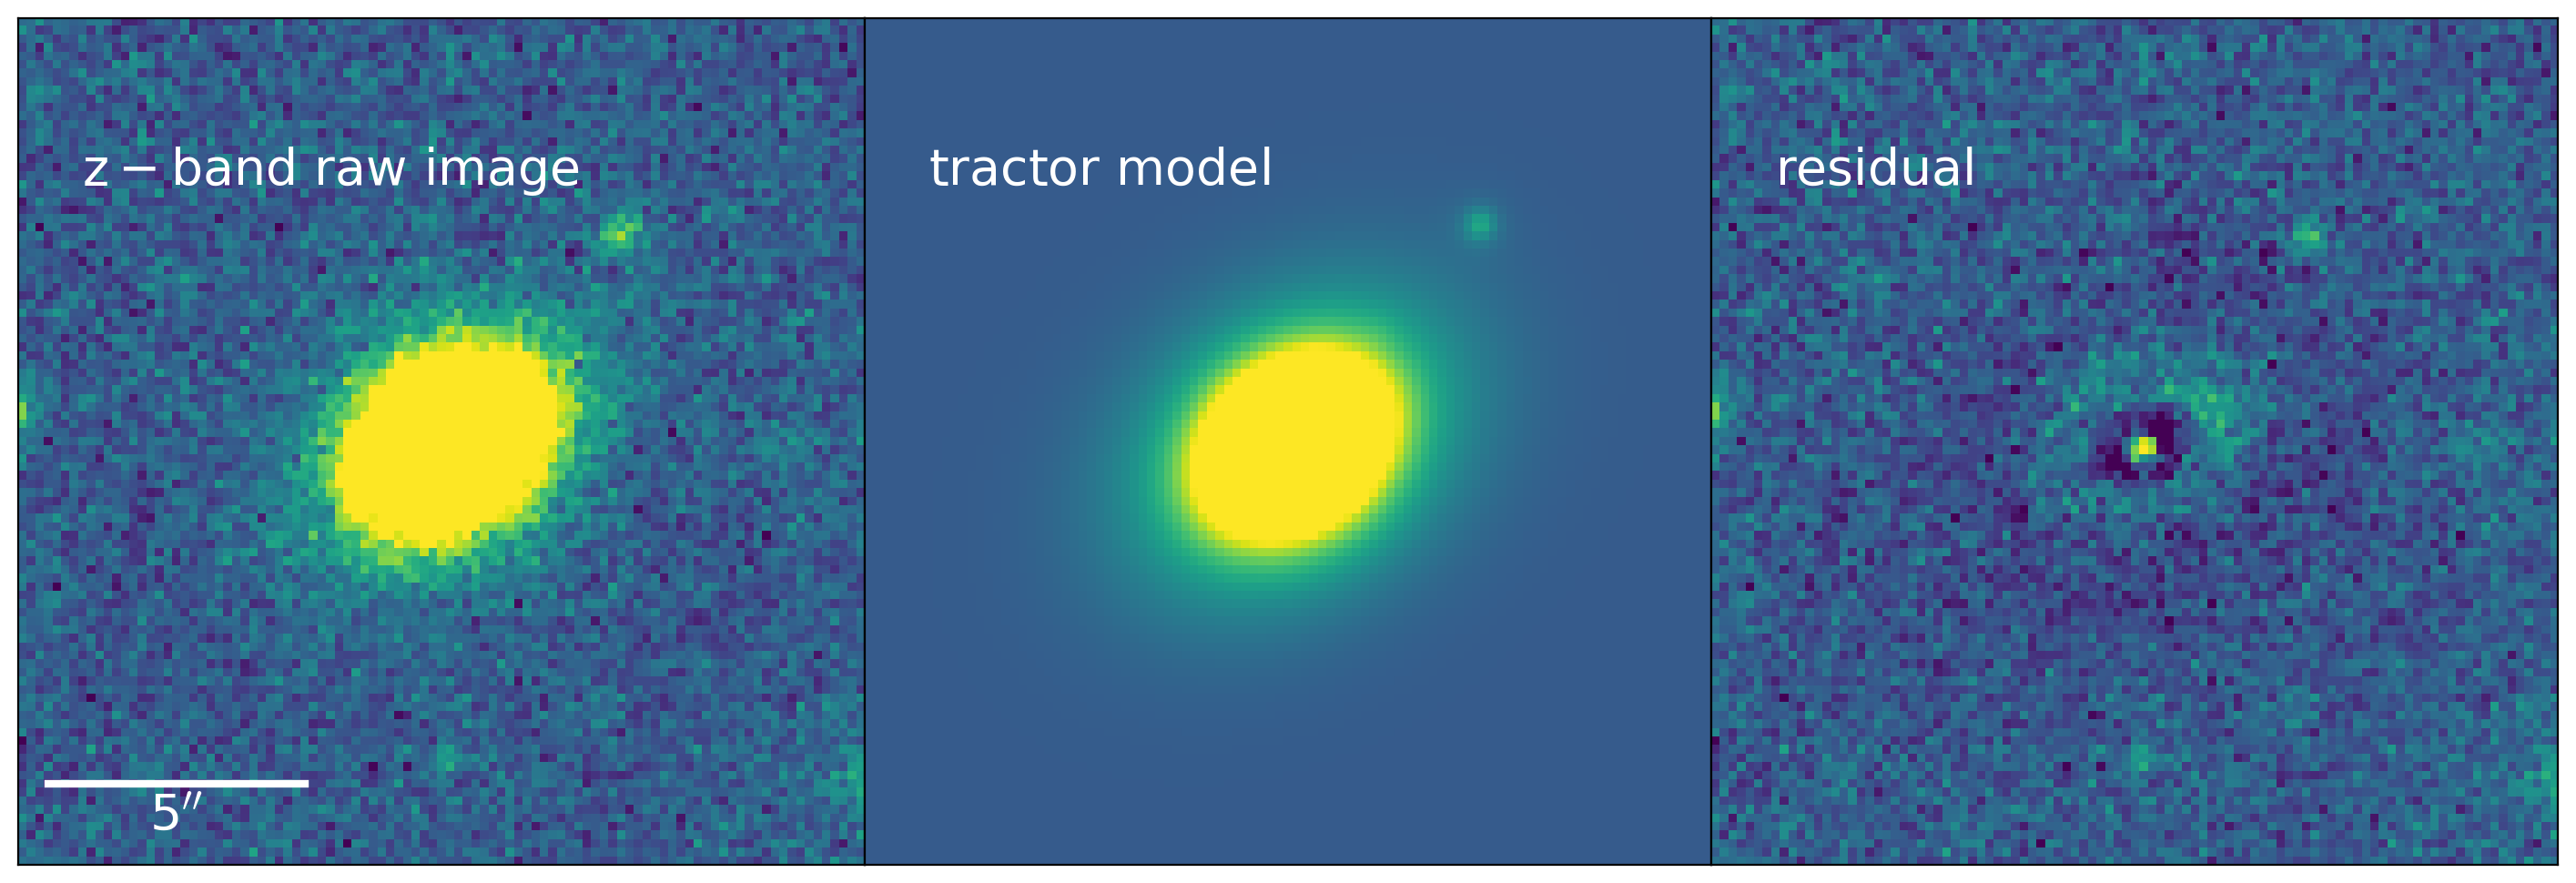

   The chi-square is 5.6987476e-05
### `ladybug_33` y-band
# Detected 1 objects
!!!The file "./tractor-1498p020.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 1
 - Now you have 1 sources
   index False out of range for table with length 0
 - Now you have 1 sources
   index False out of range for table with length 0


UnboundLocalError: local variable 'trac_obj' referenced before assignment

In [35]:
for obj in obj_cat[6:]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('ladybug_')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    
    # Start fitting
    model_dict = {}
    for filt in channels:
        model_dict[filt] = tractor_hsc_sep(obj, filt, channels, data, 
                                           brick_file='/home/diana/Research/research_downloads/survey-bricks.fits.gz',
                                           freeze_pos=False, verbose=True)
    
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
        
    ### Make figures into a PDF file (slow)
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
        pdf.image(image, 21, 11 + k * 55, 167, 55)
    pdf.output(obj_name + "_sep_tractor.pdf", "F")

    # Visualize our model
    from kuaizi.tractor.utils import HiddenPrints
    with HiddenPrints():
        model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

    stretch = 1
    Q = 0.5
    channel_map = scarlet.display.channels_to_rgb(len(channels))

    img_rgb = scarlet.display.img_to_rgb(
        data.images,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    model_rgb = scarlet.display.img_to_rgb(
        model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    res_rgb = scarlet.display.img_to_rgb(
        data.images - model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
    ax1.imshow(img_rgb, origin='lower')
    ax2.imshow(model_rgb, origin='lower')
    ax3.imshow(res_rgb, origin='lower')

    for ax in [ax1, ax2, ax3]:
        ax.axis('off')

    ax1.set_title('HSC Image (grizy)', fontsize=17)
    ax2.set_title('Tractor Model', fontsize=17)
    ax3.set_title('Residual', fontsize=17)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(obj_name + '_sep_tractor_rgb.png', 
                bbox_inches='tight', 
                metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})
    

    #clear_output()
    #plt.close()


In [27]:
obj_cat.pprint_all()

     name                               prefix                                   ra                dec               radius      
                                                                                                                     arcsec      
------------- ---------------------------------------------------------- ------------------ ------------------ ------------------
ladybug_201_y /tigress/MERIAN/poststamps/ladybug/1/201/hsc/ladybug_201_y 150.59876741037215  2.674411870156839  17.09902827648402
ladybug_180_y /tigress/MERIAN/poststamps/ladybug/1/180/hsc/ladybug_180_y  149.7636717903731  2.583695678593665  7.657890531993782
ladybug_158_y /tigress/MERIAN/poststamps/ladybug/1/158/hsc/ladybug_158_y 150.28888001293055 2.4732633249596385               20.0
ladybug_151_y /tigress/MERIAN/poststamps/ladybug/1/151/hsc/ladybug_151_y  150.3193722941879   2.45108843279511  19.05386496225897
ladybug_207_y /tigress/MERIAN/poststamps/ladybug/1/207/hsc/ladybug_207_y  150.693714994242